## Import required libraries

In [2]:
import csv
from pathlib import Path
from sys import __stdout__
from ast import literal_eval
import pickle

from configparser import ConfigParser

import numpy as np
import pandas as pd
import sklearn as sk
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Dict, Set, Tuple, List, Any, Optional, Callable
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, VarianceThreshold
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline as skPipeline
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils # type: ignore
mp_drawing_styles = mp.solutions.drawing_styles # type: ignore
mp_face_mesh = mp.solutions.face_mesh # type: ignore
mp_face_mesh_connections = mp.solutions.face_mesh_connections # type: ignore

from settings import *
from auxiliary import plot_selected_features

## Prepare the Training Data

See [./landmarkgenerator.py](./landmarkgenerator.py)

## Helper Functions for Debugging

### Plot the selected features

See [./auxiliary.py:plot_selected_features](./auxiliary.py)

## Load Train Dataset

### For Multi-task Regression

For Multi-task Regression use. All the data from the dataset CSV are load into a single dataframe, such that

$ x_{i,j} \in X, i \leq n, j \leq m $ where $X$ is a $n * m$ matrix, is the $j^{th}$ landmark of the $i^{th}$ training data element.

$ y_i \in Y, i \leq n$ where $Y$ is a $n * 1$ matrix, is the list of blendshape of that element.

In [190]:
tmp_df = pd.read_csv(TRAIN_FILE, header=0, delimiter=",", index_col=False)

# Note that each element of the dataframe is a array.
# Such that its shape is (n_samples, 1).
tmp_multitask_Y : DataFrame = tmp_df["weight"].to_frame()
tmp_multitask_Y = tmp_multitask_Y.applymap(literal_eval).applymap(np.array)

# Now we flatten the arrays in the dataframe.
# To make the shape of the dataframe to be (n_samples, n_targets).
# where n_targets is the number of blendshapes we are predicting.
multitask_Y = list()
for val in tmp_multitask_Y.values:
    multitask_Y.append(val[0])
multitask_Y = pd.DataFrame(multitask_Y)

## Assuming 1st column blendshape index and 2nd column is the weight list.
multitask_X : DataFrame = tmp_df.iloc[:, 2:]
multitask_X = multitask_X.applymap(literal_eval).applymap(np.array)

# A np array for tracking the indices of the blendshapes.
blendshape_indices = tmp_df["blendshape_i"].to_numpy()
blendshape_indices = blendshape_indices - 67

del(tmp_df, tmp_multitask_Y)

In [191]:
print(multitask_X.shape)
print(multitask_Y.shape)
print(blendshape_indices.shape)

(19392, 478)
(19392, 48)
(19392,)


### For multi models regression

All the data from the dataset CSV are load into a list of dataframes, such that

$ dataframe_i$ in list is a dataframe for a specific blendshape.

$ x_{i,j} \in X, i \leq n, j \leq m $ where $X$ is a $n * m$ matrix, is the $j^{th}$ landmark of the $i^{th}$ training data element of this specific blendshape.

$ y_i \in y, i \leq n$ where $y$ is a **vector**, is the weight of that blendshape.

In [3]:
def get_data_for_one_model( X: DataFrame, 
                            Y: DataFrame, 
                            blendshape_idx: int,
                            indices_list) -> Tuple[DataFrame, DataFrame]:
    """Get the trainning data for one blendshape.

    Args:
        X (DataFrame): X for multitask learning
        Y (DataFrame): Y for multitask learning
        blendshape_idx (int): The index of the selected blendshape.
        indices_list: The array tracking the indices of the blendshapes.

    Returns:
        Tuple[DataFrame, DataFrame]: Similar to X for multitask learning, 
                                    but only with the rows for the selected blendshape.
                                    Y is a 1D array of weights for the selected blendshape.
    """
    row_indices = [i for i in range(0, X.shape[0]) if indices_list[i] == blendshape_idx]
    X = X.iloc[row_indices, :]
    Y = Y.iloc[row_indices, blendshape_idx]
    return (X, Y)


In [193]:
subset_X, subset_Y = get_data_for_one_model(clear_multitask_X, clear_multitask_Y, 0, clear_blendshape_indices)
print(subset_X.shape, subset_Y.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312

## Data Processing

At this step, we want to process those data that not-suitable for the multi-task regression.

In [9]:
config_reader = ConfigParser()
config_reader.read('blendshapes.ini')
blendshape_configs = config_reader['blendshapes']

# Those blendshapes are in used.
# Store the index of those blendshapes.
in_used_blendshape_indices = list()
for idx, key in enumerate(blendshape_configs):
    if blendshape_configs.getboolean(key):
        in_used_blendshape_indices.append(idx)

# Figure out the corresponding rows in the multitask_X.
# We know that for each blendshape,
# there n_training_samples and n_avatar in total.
n_training_samples = 101
n_avatar = 4
in_used_multitask_X_row = list()
for i in range(0, n_avatar):
    this_avatar_first_row = n_training_samples * N_BLENDSHAPE * i
    for idx in in_used_blendshape_indices:
        for j in range(0, n_training_samples):
            this_blendshape_first_row = this_avatar_first_row + idx * n_training_samples
            in_used_multitask_X_row.append(this_blendshape_first_row + j)

clear_multitask_X = multitask_X.iloc[in_used_multitask_X_row]
clear_multitask_Y = multitask_Y.iloc[in_used_multitask_X_row]
clear_blendshape_indices = np.take(blendshape_indices, in_used_multitask_X_row)

In [10]:
print("Indices in used:", in_used_blendshape_indices)
print("shape of clear_multitask_X:", clear_multitask_X.shape)
print("shape of clear_multitask_Y:", clear_multitask_Y.shape)
print(len(clear_blendshape_indices))

Indices in used: [0, 1, 3, 4, 16, 17, 22, 32, 44, 45, 46, 47]
shape of clear_multitask_X: (4848, 478)
shape of clear_multitask_Y: (4848, 48)
4848


In [197]:
# Store the data in case crash, for saving time.
with open("tmp/clear_multitask_X.pkl", "wb") as f:
    pickle.dump(clear_multitask_X, f)
with open("tmp/clear_multitask_Y.pkl", "wb") as f:
    pickle.dump(clear_multitask_Y, f)
with open("tmp/clear_blendshape_indices.pkl", "wb") as f:
    pickle.dump(clear_blendshape_indices, f)

In [4]:
# Restore the variable from pkl.
with open("tmp/clear_multitask_X.pkl", "rb") as f:
    clear_multitask_X = pickle.load(f)
with open("tmp/clear_multitask_Y.pkl", "rb") as f:
    clear_multitask_Y = pickle.load(f)
with open("tmp/clear_blendshape_indices.pkl", "rb") as f:
    clear_blendshape_indices = pickle.load(f)

## Transforming Dataset

### Full Distance

The training set base on distances that includes all the points, labelled by their index in MediaPipe.

In [5]:
class FullDistance(BaseEstimator, TransformerMixin):

    def __init__(self, distance_type: str = 'full'):
        """_summary_

        Args:
            is_full (bool, optional): Using the full distance or the refine distance. Defaults to True.
        """
        super().__init__()
        self.distance_type = distance_type
        self.selected_vertex_array = [0, 7, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58, 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105, 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191, 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291, 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324, 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409, 415, 454, 466, 469, 470, 471, 472, 474, 475, 476, 477]

    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.distance_type == "full":
            return self._full_transform(X, y)
        elif self.distance_type == "refine":
            return self._refine_transform(X, y)

    def _full_transform(self, X, y=None):
        """Produce the training set with distance between center and all the landmarks

        Args:
            input_df (DataFrame): the origin dataframe from csv file

        Returns:
            DataFrame: the training set with distance between landmarks
        """

        NOSE_IDX = 4
        TOP_DOWN_FACE = (10,152)

        # define the column names
        new_columns = list()
        for idx, _ in enumerate(X.columns):
            new_columns.append(f"distance_{idx}")

        distance_X = DataFrame(columns=new_columns, dtype=np.float64)

        for i, row in X.iterrows():
            new_row = list()
            middle_point = np.copy(row[NOSE_IDX])
            middle_point[1] = (row[TOP_DOWN_FACE[0]][1] + row[TOP_DOWN_FACE[1]][1]) / 2
            middle_point[2] = 0
            max_distance = row[TOP_DOWN_FACE[0]] - row[TOP_DOWN_FACE[1]]
            max_distance[2] = 0
            normalised_distance = np.linalg.norm(max_distance)
            for _, landmark in enumerate(row):
                landmark_copy = np.copy(landmark)
                landmark_copy[2] = 0
                distance = np.linalg.norm(landmark_copy - middle_point)
                new_row.append(distance)
            distance_X.loc[i] = [distance / normalised_distance for distance in new_row] # type: ignore
        return distance_X

    def _refine_transform(self, X, y=None):
        """Produce the training set with distance between center and a subset of all landmarks

        Args:
            input_df (DataFrame): the origin dataframe from csv file

        Returns:
            DataFrame: the training set with distance between landmarks
        """

        NOSE_IDX = 4
        TOP_DOWN_FACE = (10,152)

        # define the column names
        new_columns = list()
        for idx, _ in enumerate(self.selected_vertex_array):
            new_columns.append(f"distance_{idx}")

        distance_X = DataFrame(columns=new_columns, dtype=np.float64)

        for i, row in X.iterrows():
            new_row = list()
            middle_point = np.copy(row[NOSE_IDX])
            middle_point[1] = (row[TOP_DOWN_FACE[0]][1] + row[TOP_DOWN_FACE[1]][1]) / 2
            middle_point[2] = 0
            max_distance = row[TOP_DOWN_FACE[0]] - row[TOP_DOWN_FACE[1]]
            max_distance[2] = 0
            normalised_distance = np.linalg.norm(max_distance)
            for idx in self.selected_vertex_array:
                landmark = row[idx]
                landmark_copy = np.copy(landmark)
                landmark_copy[2] = 0
                distance = np.linalg.norm(landmark_copy - middle_point)
                new_row.append(distance)
            distance_X.loc[i] = [distance / normalised_distance for distance in new_row] # type: ignore
        return distance_X

This following cell shows how the hard coded index list from above is generated.

In [32]:
# Since the performance for this part is not a matter
# So we simply implement in the way that it could achieve the goal.
vertices_sets: Dict[str, Set[Tuple[int, int]]] = {
    "FACEMESH_FACE_OVAL": mp_face_mesh_connections.FACEMESH_FACE_OVAL,
    "FACEMESH_LIPS": mp_face_mesh_connections.FACEMESH_LIPS, 
    "FACEMESH_LEFT_EYE": mp_face_mesh_connections.FACEMESH_LEFT_EYE,
    "FACEMESH_LEFT_IRIS": mp_face_mesh_connections.FACEMESH_LEFT_IRIS,
    "FACEMESH_LEFT_EYEBROW": mp_face_mesh_connections.FACEMESH_LEFT_EYEBROW,
    "FACEMESH_RIGHT_EYE": mp_face_mesh_connections.FACEMESH_RIGHT_EYE,
    "FACEMESH_RIGHT_EYEBROW": mp_face_mesh_connections.FACEMESH_RIGHT_EYEBROW,
    "FACEMESH_RIGHT_IRIS": mp_face_mesh_connections.FACEMESH_RIGHT_IRIS}
vertices_set = set()
for value in vertices_sets.values():
    for a, b in value:
        vertices_set.add(a)
        vertices_set.add(b)
selected_vertex_array = sorted(list(vertices_set))
print(selected_vertex_array)
print(len(selected_vertex_array))


[0, 7, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58, 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105, 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191, 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291, 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324, 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409, 415, 454, 466, 469, 470, 471, 472, 474, 475, 476, 477]
136


## Features selection

### Selected K Best

In [60]:
selection_k_best_chi2 = SelectKBest(chi2, k=5)

### VarianceThreshold

a customized version of VarianceThreshold

In [8]:
class CustomVarianceThreshold(VarianceThreshold):

    def __init__(self, threshold=0.0, step=1.0e-7, max_iteration=1000):
        super().__init__(threshold=threshold)
        self.try_count = 0
        self.step = step
        self.max_iteration = max_iteration
    
    def fit_transform(self, X, y = None, **fit_params):
        try:
            return super().fit_transform(X, y, **fit_params)
        except ValueError:
            while True:
                self.threshold -= self.threshold
                if self.try_count > self.max_iteration:
                    self.threshold=0
                    print("No suitable threshold, new threshold = 0")
                    return super().fit_transform(X, y, **fit_params)
                self.max_iteration += 1
                try:
                    return super().fit_transform(X, y, **fit_params)
                except ValueError:
                    continue

## Training Multi-task Model

### Multilasso

In [46]:
fulldistance_multilasso = skPipeline(steps=[('data_transform', FullDistance()), ('regression', MultiTaskLasso())])
fulldistance_multilasso_search = GridSearchCV(estimator=fulldistance_multilasso,
             param_grid={'regression__alpha' : [0.5, 1.0, 1.5],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_multilasso_search.fit(clear_multitask_X, clear_multitask_Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.903) neg_mean_squared_error: (test=-63.448) r2: (test=0.747) total time=  45.6s
[CV 2/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.929) neg_mean_squared_error: (test=-67.247) r2: (test=0.574) total time=  41.5s
[CV 3/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.924) neg_mean_squared_error: (test=-65.388) r2: (test=0.749) total time=  42.1s
[CV 4/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.915) neg_mean_squared_error: (test=-65.596) r2: (test=0.732) total time=  44.9s
[CV 5/5] END regression__alpha=0.5; neg_mean_absolute_error: (test=-1.944) neg_mean_squared_error: (test=-68.230) r2: (test=0.749) total time=  41.5s
[CV 1/5] END regression__alpha=1.0; neg_mean_absolute_error: (test=-1.903) neg_mean_squared_error: (test=-63.448) r2: (test=0.747) total time=  42.2s
[CV 2/5] END regression__alpha=1.0; neg_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression', MultiTaskLasso())]),
             param_grid={'regression__alpha': [0.5, 1.0, 1.5]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [47]:
for item in fulldistance_multilasso_search.cv_results_.items():
    print(item)
fulldistance_multilasso_search.best_estimator_

('mean_fit_time', array([38.04458838, 38.41220503, 37.28625612]))
('std_fit_time', array([1.60162758, 1.27323016, 0.36441486]))
('mean_score_time', array([5.06848125, 4.98422523, 5.0977015 ]))
('std_score_time', array([0.2938699 , 0.20442274, 0.39584178]))
('param_regression__alpha', masked_array(data=[0.5, 1.0, 1.5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object))
('params', [{'regression__alpha': 0.5}, {'regression__alpha': 1.0}, {'regression__alpha': 1.5}])
('split0_test_neg_mean_absolute_error', array([-1.90304123, -1.90304123, -1.90304123]))
('split1_test_neg_mean_absolute_error', array([-1.9291454, -1.9291454, -1.9291454]))
('split2_test_neg_mean_absolute_error', array([-1.92359542, -1.92359542, -1.92359542]))
('split3_test_neg_mean_absolute_error', array([-1.91506999, -1.91506999, -1.91506999]))
('split4_test_neg_mean_absolute_error', array([-1.94361531, -1.94361531, -1.94361531]))
('mean_test_neg_mean_absolute_error', array([-1.9228934

Pipeline(steps=[('data_transform', FullDistance()),
                ('regression', MultiTaskLasso(alpha=0.5))])

In [48]:
with open('tmp/fulldistance_multilasso_search.pkl', 'wb') as file:
    pickle.dump(fulldistance_multilasso_search, file)

In [ ]:
with open('tmp/fulldistance_multilasso_search.pkl', 'rb') as file:
    fulldistance_multilasso_search = pickle.load(fulldistance_multilasso_search, file)

### Decision Tree Multi-task Regression

In [111]:
fulldistance_dtregression = skPipeline(steps=[('data_transform', FullDistance()), ('regression', DecisionTreeRegressor())])
fulldistance_dtregression.fit(clear_multitask_X, clear_multitask_Y)
fulldistance_dtregression_search = GridSearchCV(estimator=fulldistance_dtregression,
             param_grid={   'data_transform__distance_type': ['refine'],
                            'regression__min_samples_split' : [2, 5, 10, 20, 30],
                            'regression__max_depth' : [None, 10, 20, 30],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_dtregression_search.fit(clear_multitask_X, clear_multitask_Y)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END data_transform__distance_type=refine, regression__max_depth=None, regression__min_samples_split=2; neg_mean_absolute_error: (test=-1.600) neg_mean_squared_error: (test=-99.305) r2: (test=0.621) total time=  15.6s
[CV 2/2] END data_transform__distance_type=refine, regression__max_depth=None, regression__min_samples_split=2; neg_mean_absolute_error: (test=-1.615) neg_mean_squared_error: (test=-101.984) r2: (test=0.610) total time=  14.6s
[CV 1/2] END data_transform__distance_type=refine, regression__max_depth=None, regression__min_samples_split=5; neg_mean_absolute_error: (test=-1.547) neg_mean_squared_error: (test=-94.155) r2: (test=0.640) total time=  14.0s
[CV 2/2] END data_transform__distance_type=refine, regression__max_depth=None, regression__min_samples_split=5; neg_mean_absolute_error: (test=-1.626) neg_mean_squared_error: (test=-102.025) r2: (test=0.610) total time=  14.4s
[CV 1/2] END data_transform__dist

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression',
                                        DecisionTreeRegressor())]),
             param_grid={'data_transform__distance_type': ['refine'],
                         'regression__max_depth': [None, 10, 20, 30],
                         'regression__min_samples_split': [2, 5, 10, 20, 30]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

Pipeline(steps=[('data_transform', FullDistance()),
                ('regression',
                 DecisionTreeRegressor(max_depth=10, min_samples_split=5))])


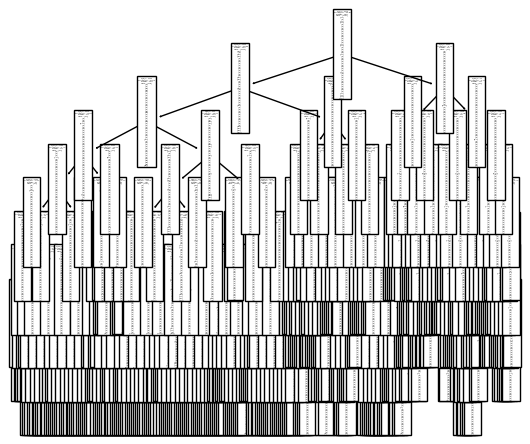

In [182]:
import sklearn.tree as tree
print(fulldistance_dtregression_search.best_estimator_)
best_dt = fulldistance_dtregression_search.best_estimator_.named_steps['regression']
tree.plot_tree(best_dt) 
plt.show()

In [112]:
# Store the models to file.
with open('tmp/fulldistance_dtregression_search.pkl', 'wb') as file:
    pickle.dump(fulldistance_dtregression_search, file)

In [106]:
# Load the models from file.
with open('tmp/fulldistance_dtregression_search.pkl', 'rb') as file:
    fulldistance_dtregression_search = pickle.load(file)

### KNN 

In [150]:
fulldistance_knnregression = skPipeline(steps=[('data_transform', FullDistance()), ('regression', RadiusNeighborsRegressor(weights='distance'))])
fulldistance_knnregression.fit(clear_multitask_X, clear_multitask_Y)
fulldistance_knnregression_search = GridSearchCV(estimator=fulldistance_knnregression,
             param_grid={   'data_transform__distance_type' : ['refine', 'full'],
                            'regression__radius' : [0.25, 0.5, 1.0,],
                            'regression__weights' :['uniform', 'distance']},
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=3)
fulldistance_knnregression_search.fit(clear_multitask_X, clear_multitask_Y)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END data_transform__distance_type=refine, regression__radius=0.25, regression__weights=uniform; neg_mean_absolute_error: (test=-1.705) neg_mean_squared_error: (test=-55.950) r2: (test=0.769) total time=  15.4s
[CV 2/5] END data_transform__distance_type=refine, regression__radius=0.25, regression__weights=uniform; neg_mean_absolute_error: (test=-1.887) neg_mean_squared_error: (test=-66.399) r2: (test=0.736) total time=  43.5s
[CV 3/5] END data_transform__distance_type=refine, regression__radius=0.25, regression__weights=uniform; neg_mean_absolute_error: (test=-1.817) neg_mean_squared_error: (test=-60.108) r2: (test=0.766) total time=  32.3s
[CV 4/5] END data_transform__distance_type=refine, regression__radius=0.25, regression__weights=uniform; neg_mean_absolute_error: (test=-1.828) neg_mean_squared_error: (test=-61.329) r2: (test=0.743) total time=  14.8s
[CV 5/5] END data_transform__distance_type=refine, regression__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transform', FullDistance()),
                                       ('regression',
                                        RadiusNeighborsRegressor(weights='distance'))]),
             param_grid={'data_transform__distance_type': ['refine', 'full'],
                         'regression__radius': [0.25, 0.5, 1.0],
                         'regression__weights': ['uniform', 'distance']},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                      'r2'],
             verbose=3)

In [152]:
for item in fulldistance_knnregression_search.cv_results_.items():
    print(item)

('mean_fit_time', array([20.23875446, 31.28126659, 14.29081903, 22.88301663, 20.5489152 ,
       12.12704549, 35.66176376, 34.52743821, 35.6301734 , 35.32302332,
       35.44189787, 33.3182528 ]))
('std_fit_time', array([ 9.90431814, 13.56869011,  1.22504402, 10.93432366,  9.56827619,
        0.35187043,  0.53291483,  0.31498537,  1.42659962,  0.41666694,
        0.41734845,  0.68997895]))
('mean_score_time', array([5.41769662, 7.48532205, 3.47687941, 6.11465054, 4.02364902,
       3.07793984, 5.00033641, 5.06638899, 5.27118359, 5.50134225,
       5.31545739, 5.46502318]))
('std_score_time', array([3.12626753, 3.93346776, 0.59393171, 2.35466562, 1.75006613,
       0.03476105, 0.07724381, 0.08563162, 0.09118966, 0.04105681,
       0.05279246, 0.21392724]))
('param_data_transform__distance_type', masked_array(data=['refine', 'refine', 'refine', 'refine', 'refine',
                   'refine', 'full', 'full', 'full', 'full', 'full',
                   'full'],
             mask=[False, Fa

In [151]:
# Store the models to file.
with open('tmp/fulldistance_knnregression_search.pkl', 'wb') as file:
    pickle.dump(fulldistance_knnregression_search, file)

In [81]:
# Load the models from file.
with open('tmp/fulldistance_knnregression_search.pkl', 'rb') as file:
    fulldistance_knnregression_search = pickle.load(file)
with open('tmp/refinedistance_knnregression_search.pkl', 'rb') as file:
    refinedistance_knnregression_search = pickle.load(file)

## Training multi models for multi output

### Adaboost

In [11]:
adaboost_searches = dict()
for idx in in_used_blendshape_indices:
    cur_X, cur_Y = get_data_for_one_model(clear_multitask_X, clear_multitask_Y, idx, clear_blendshape_indices)
    fulldistance_adabooster = skPipeline(steps=[('data_transform', FullDistance()), ('regression', AdaBoostRegressor())])
    fulldistance_adabooster_search = GridSearchCV(estimator=fulldistance_adabooster,
             param_grid={'regression__n_estimators' : [25, 50, 100],
                         'regression__learning_rate' : [0.25, 0.5, 1.0]},
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=1)
    fulldistance_adabooster_search.fit(cur_X, cur_Y)
    adaboost_searches[str(idx)] = fulldistance_adabooster_search

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [132]:
with open('tmp/adaboost_searches.pkl', 'wb') as file:
    pickle.dump(adaboost_searches, file)

In [255]:
with open('tmp/adaboost_searches.pkl', 'rb') as file:
    adaboost_searches = pickle.load(file)

### Linear Regression

In [199]:
fulldistance_classic_linear_searches = dict()
for idx in in_used_blendshape_indices:
    cur_X, cur_Y = get_data_for_one_model(clear_multitask_X, clear_multitask_Y, idx, clear_blendshape_indices)
    fulldistance_classic_linear = skPipeline(steps=[('data_transform', FullDistance()), 
        ('feature_selection', CustomVarianceThreshold()), ('regression', LinearRegression())])
    fulldistance_classic_linear_search = GridSearchCV(estimator=fulldistance_classic_linear,
             param_grid={'feature_selection__threshold': [1e-5, 1e-6, 1e-7]},
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='r2',
             cv=5,
             verbose=1)
    fulldistance_classic_linear_search.fit(cur_X, cur_Y)
    fulldistance_classic_linear_searches[str(idx)] = fulldistance_classic_linear_search

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312

In [200]:
for search in fulldistance_classic_linear_searches.values():
    print(max(search.cv_results_['mean_test_r2']))

0.9259175939925306
0.7375367940770915
0.7198136840417082
0.7717259392168488
-0.42708467555758894
0.8247332950669627
0.5978581979878893
0.948624017795639
0.7324824483640919
0.831970022274839
0.655323511422132
0.7129670440170296


### Decision Tree

In [227]:
distance_multi_dt_searches = dict()
for idx in in_used_blendshape_indices:
    cur_X, cur_Y = get_data_for_one_model(clear_multitask_X, clear_multitask_Y, idx, clear_blendshape_indices)
    distance_multi_dt = skPipeline(steps=[('data_transform', FullDistance()), ('regression', DecisionTreeRegressor())])
    distance_multi_dt_search = GridSearchCV(estimator=distance_multi_dt,
             param_grid={   'data_transform__distance_type': ['refine'],
                            'regression__min_samples_split' : [2, 5, 10, 20, 30],
                            'regression__max_depth' : [None, 10, 20, 30],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='r2',
             cv=5,
             verbose=1)
    distance_multi_dt_search.fit(cur_X, cur_Y)
    distance_multi_dt_searches[str(idx)] = distance_multi_dt_search

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [228]:
with open('tmp/distance_multi_dt_searches.pkl', 'wb') as file:
    pickle.dump(distance_multi_dt_searches, file)

In [160]:
for search in distance_multi_dt_searches.values():
    print(max(search.cv_results_['mean_test_r2']))

0.20257325701139992
0.6482193093628675
0.5006532054169647
0.5741555670136397
-0.9207703237392343
-0.6251282869978088
-0.6302237322317898
0.8831020756422177
-0.6295063630080977
-0.8265952144575331
-1.5299154916314337
0.10590865535237223


In [7]:
with open('tmp/distance_multi_dt_searches.pkl', 'rb') as file:
     distance_multi_dt_searches = pickle.load(file)

### Epsilon-SVM Regression

In [ ]:
distance_multi_epsilon_svr_searches = dict()
for idx in in_used_blendshape_indices:
    cur_X, cur_Y = get_data_for_one_model(clear_multitask_X, clear_multitask_Y, idx, clear_blendshape_indices)
    distance_multi_epsilon_svr = skPipeline(steps=[('data_transform', FullDistance()), ('feature_selection', CustomVarianceThreshold()), ('regression', SVR())])
    distance_multi_epsilon_svr_search = GridSearchCV(estimator=distance_multi_dt,
             param_grid={   'data_transform__distance_type': ['full', 'refine'],
                            'feature_selection__threshold': [1e-5, 1e-6, 1e-7],
                            'regression__kernel' : ['linear', 'rbf'],
                            'regression__C' : [0.5, 1.0, 1.5],
                            'regression__epsilon' : [0.05, 0.1, 0.2],
                            'regression__gamma' : ['scale', 1e-3, 1e-4, 1e-5],
                        },
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
             refit='neg_mean_squared_error',
             cv=5,
             verbose=1)
    distance_multi_epsilon_svr_search.fit(cur_X, cur_Y)
    distance_multi_epsilon_svr_searches[str(idx)] = distance_multi_epsilon_svr_search

In [ ]:
with open('tmp/distance_multi_epsilon_svr_searches.pkl', 'rb') as file:
    distance_multi_epsilon_svr_searches = pickle.load(file)

In [67]:
for search in distance_multi_epsilon_svr_searches.values():
    print(search.cv_results_['mean_test_neg_mean_absolute_error'])

[-25.14942572 -25.18318441 -25.14942572 -25.18318441 -25.14819325
 -25.18214571 -25.06193051 -25.11999458 -25.06017443 -25.11999458
 -25.05964152 -25.11999458 -24.9778105  -25.05860007 -24.9778105
 -25.05860007 -24.9778105  -25.06214246 -25.13560684 -25.20213113
 -25.13560684 -25.20159528 -25.1352344  -25.20159528 -25.03629727
 -25.15673751 -25.03453843 -25.15673751 -25.03382921 -25.1556658
 -24.94159125 -25.11203286 -24.94159125 -25.11203286 -24.94159125
 -25.11203286 -25.13550905 -25.20661033 -25.13550905 -25.2061547
 -25.13511513 -25.2061547  -25.0361105  -25.16569591 -25.03435163
 -25.16569591 -25.03364209 -25.16478464 -24.94132274 -25.12478287
 -24.94132274 -25.12478287 -24.94132274 -25.12478287 -25.19678991
 -25.01355235 -25.19635121 -25.01355235 -25.19572999 -25.01355235
 -25.14605507 -24.79343043 -25.14605507 -24.79343043 -25.14517768
 -24.79729399 -25.09532024 -24.59636376 -25.09532024 -24.59636376
 -25.09532024 -24.59636376 -25.19365467 -25.1138144  -25.19321484
 -25.1138144 

## Test on a single static input

In [ ]:
def get_selected_point_idx(feature_name: str) -> int:
    return int(feature_name.split("_")[-1])

res = []

IDX = 99
WEIGHT = 100
IMAGE_FILES = []

# Was originally on MediaPipe's official webpage,
# But after an update, they remove the original page that provide the following code,
# So I provide the link to their GitHub instead.
# Reference: https://github.com/google/mediapipe/tree/master
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
) as face_mesh:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            continue
        annotated_image = image.copy()
        arr = []
        for face_landmarks in results.multi_face_landmarks:
            for a in face_landmarks.landmark:
                arr.append(np.array([a.x, a.y, a.z]))
        predict_df = pd.DataFrame([arr], columns=HEADERS[2:])
        res = [0 for i in range(N_BLENDSHAPE)]
        for idx, search in enumerate(distance_multi_dt_searches.values()):
            res[in_used_blendshape_indices[idx]] = int(search.best_estimator_.predict(predict_df)[0])
        print(res)
            

## Export the ideal models

In [18]:
# Since our best estimation is given by multiple models of decision tree.
# So we need to export multiple models for each prediction.
# A different implementation is needed if only one model of multi-task is used.
best_searches = adaboost_searches
for idx, search in enumerate(best_searches.values()):
    file_name = f"estimator-index{in_used_blendshape_indices[idx]}"
    with open(f"estimators/{file_name}.pkl", 'wb') as file:
        pickle.dump(search.best_estimator_, file)

## Drawing Target against Feature

In [243]:
distance_X = ModifyFullDistance().transform(clear_multitask_X)

(4848, 478)
(4848, 48)


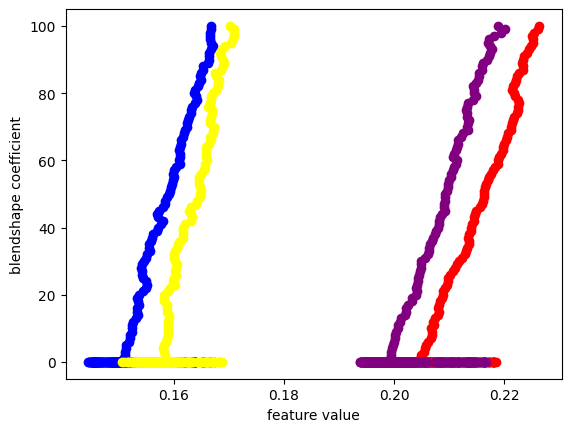

In [244]:
n_blendshape = len(in_used_blendshape_indices) * 101
selected_feature_idx = 300
selected_target_idx = 1

print(distance_X.shape)
print(clear_multitask_Y.shape)

fig, axes = plt.subplots()

colors = ["red","blue","yellow","purple"]
for i, color in enumerate(colors):
    axes.scatter(distance_X.iloc[i*n_blendshape:(i+1)*n_blendshape, selected_feature_idx], 
                clear_multitask_Y.iloc[i*n_blendshape:(i+1)*n_blendshape, selected_target_idx], c=color)
axes.set_xlabel("feature value")
axes.set_ylabel("blendshape coefficient")
plt.show()

## Test the best model


First, we import the test data, and process it

In [12]:
tmp_test_df = pd.read_csv("../test.csv", header=0, delimiter=",", index_col=False)

# Note that each element of the dataframe is a array.
# Such that its shape is (n_samples, 1).
tmp_test_Y : DataFrame = tmp_test_df["weight"].to_frame()
tmp_test_Y = tmp_test_Y.applymap(literal_eval).applymap(np.array)

# Now we flatten the arrays in the dataframe.
# To make the shape of the dataframe to be (n_samples, n_targets).
# where n_targets is the number of blendshapes we are predicting.
test_Y = list()
for val in tmp_test_Y.values:
    test_Y.append(val[0])
test_Y = pd.DataFrame(test_Y)

## Assuming 1st column blendshape index and 2nd column is the weight list.
test_X : DataFrame = tmp_test_df.iloc[:, 2:]
test_X = test_X.applymap(literal_eval).applymap(np.array)

# A np array for tracking the indices of the blendshapes.
test_blendshape_indices = tmp_test_df["blendshape_i"].to_numpy()
test_blendshape_indices = test_blendshape_indices - 67

del(tmp_test_df, tmp_test_Y)

In [13]:
print(test_X.shape, test_Y.shape)
print(in_used_blendshape_indices)

(1007, 478) (1007, 48)
[0, 1, 3, 4, 16, 17, 22, 32, 44, 45, 46, 47]


### For multi models

Max score: 0.9333534668281155 ; min score: -1.151722694330835


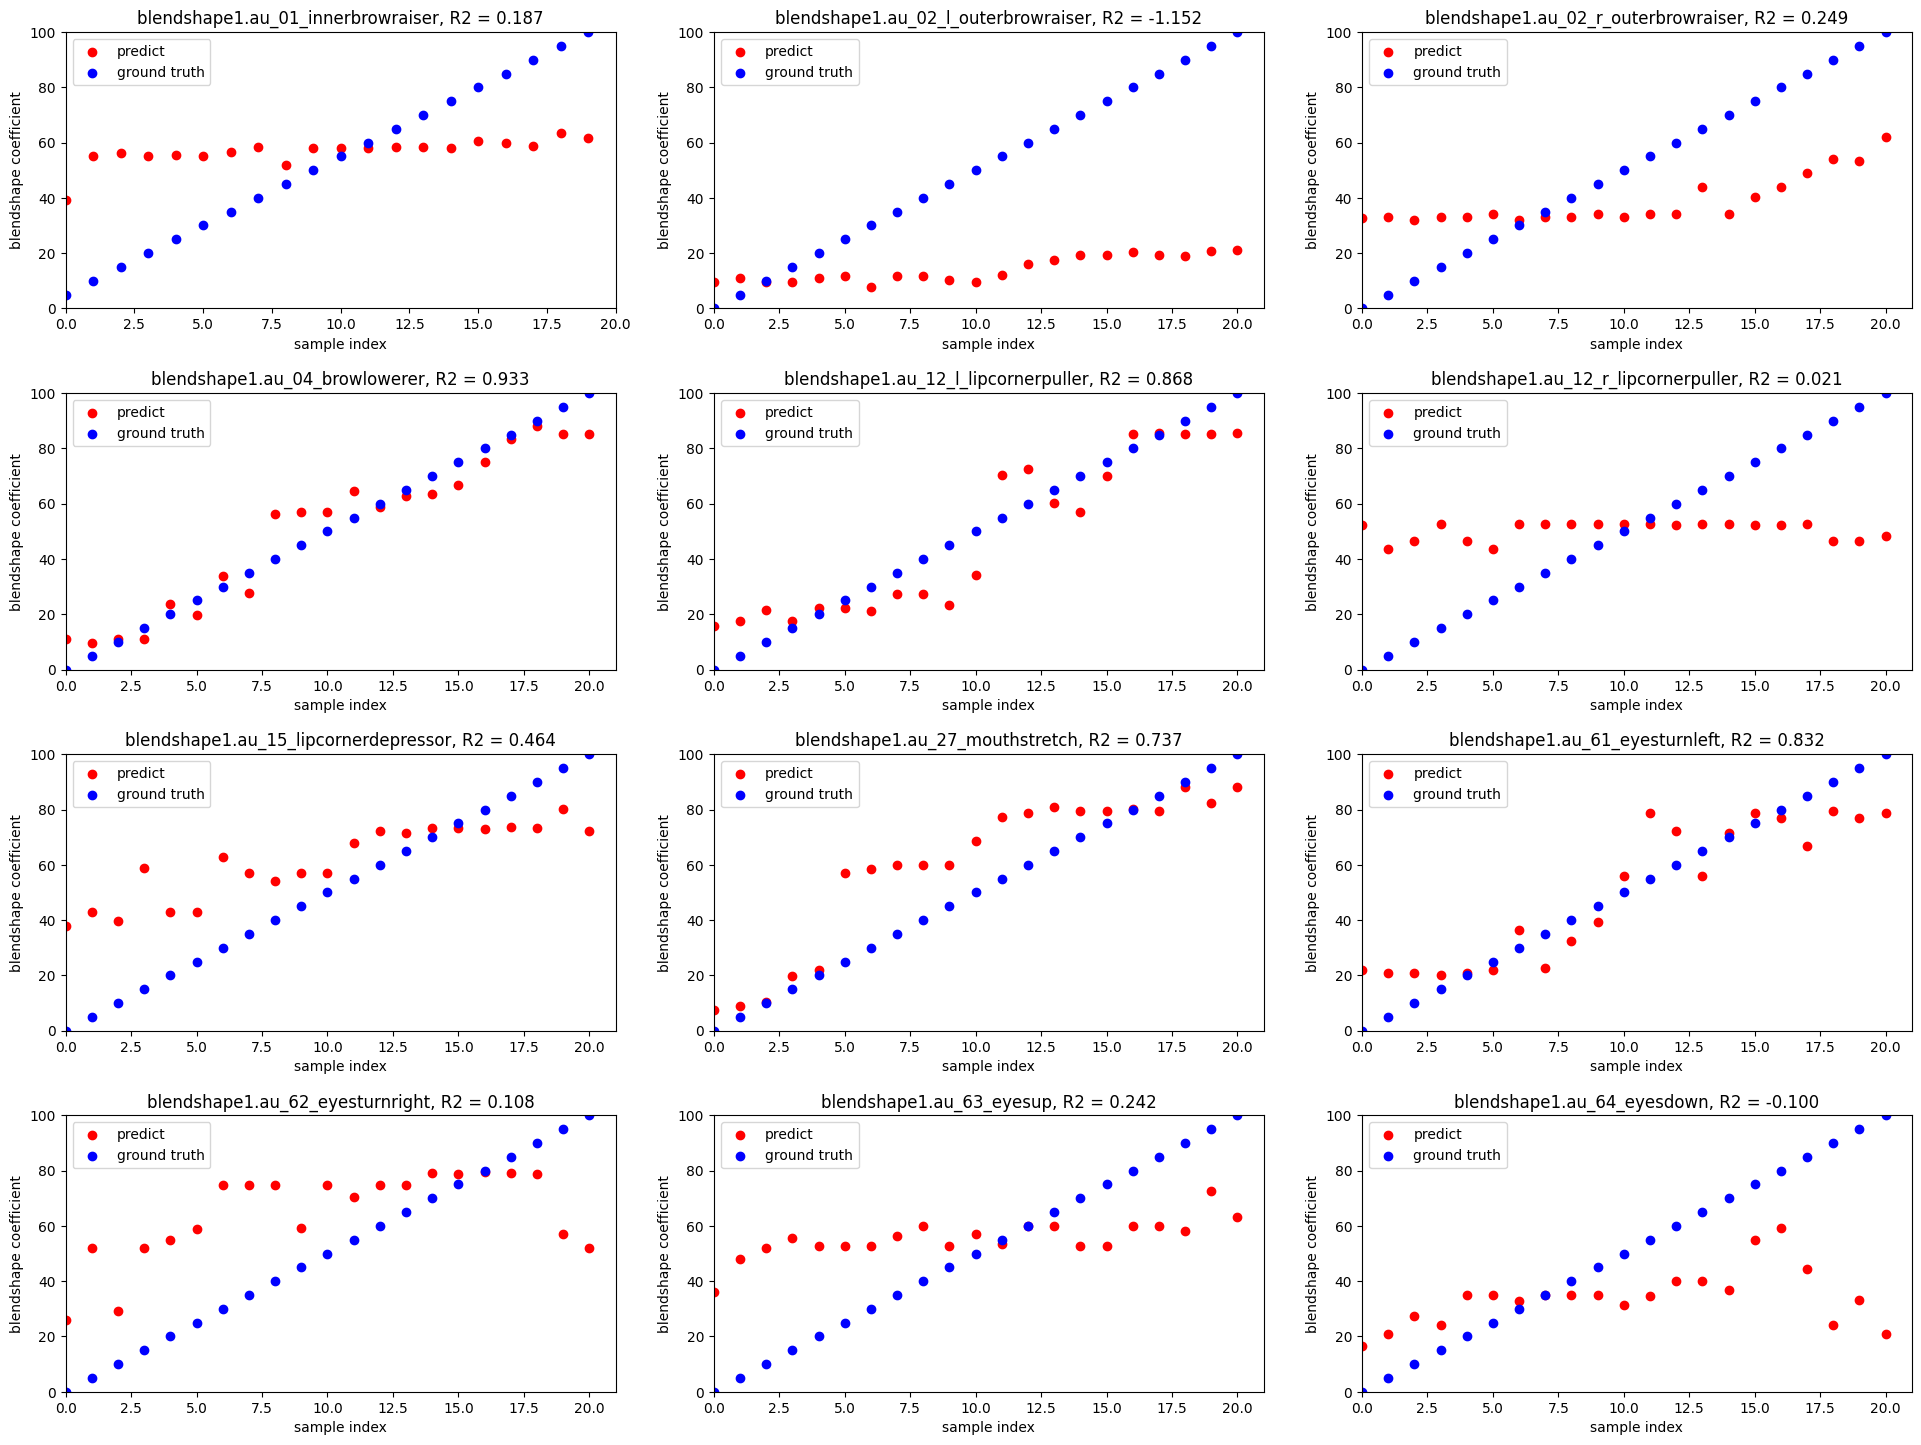

In [17]:
ncols = 3
nrows = (len(in_used_blendshape_indices) // ncols) \
    if len(in_used_blendshape_indices) % ncols == 0 \
    else (len(in_used_blendshape_indices) // ncols + 1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
fig.tight_layout(pad = 4.0)

res = []
blendshape_name = list(blendshape_configs.keys())
# Modify here if another model is need to evaluate.
evaluating_search = adaboost_searches

for idx, blendshape_idx in enumerate(in_used_blendshape_indices):
    search = evaluating_search[str(blendshape_idx)]
    estimator = search.best_estimator_
    cur_test_X, cur_test_Y = get_data_for_one_model(test_X, test_Y, blendshape_idx, test_blendshape_indices)
    n_test_samples = cur_test_Y.shape[0]
    sample_idx = [i for i in range(n_test_samples)]
    predict_y = estimator.predict(cur_test_X)
    score = estimator.score(cur_test_X, cur_test_Y)
    res.append(score)
    cur_axes = axes[idx // ncols][idx % ncols]
    cur_axes.set_xlim(0, n_test_samples)
    cur_axes.set_ylim(0, 100)
    cur_axes.scatter(sample_idx, predict_y, c='red', label='predict')
    cur_axes.scatter(sample_idx, cur_test_Y, c='blue', label='ground truth')
    cur_axes.set_title(f"{blendshape_name[blendshape_idx]}, R2 = {score:.3f}")
    cur_axes.set_xlabel("sample index")
    cur_axes.set_ylabel("blendshape coefficient")
    cur_axes.legend()

print("Max score:", max(res), "; min score:",  min(res))


In [173]:
evaluating_search = list(fulldistance_classic_linear_searches.values())[0]
estimator  = evaluating_search.best_estimator_
print(estimator.named_steps['regression'].n_features_in_)

443


### For multi-task Model

Max score: 60 ; min score: 0


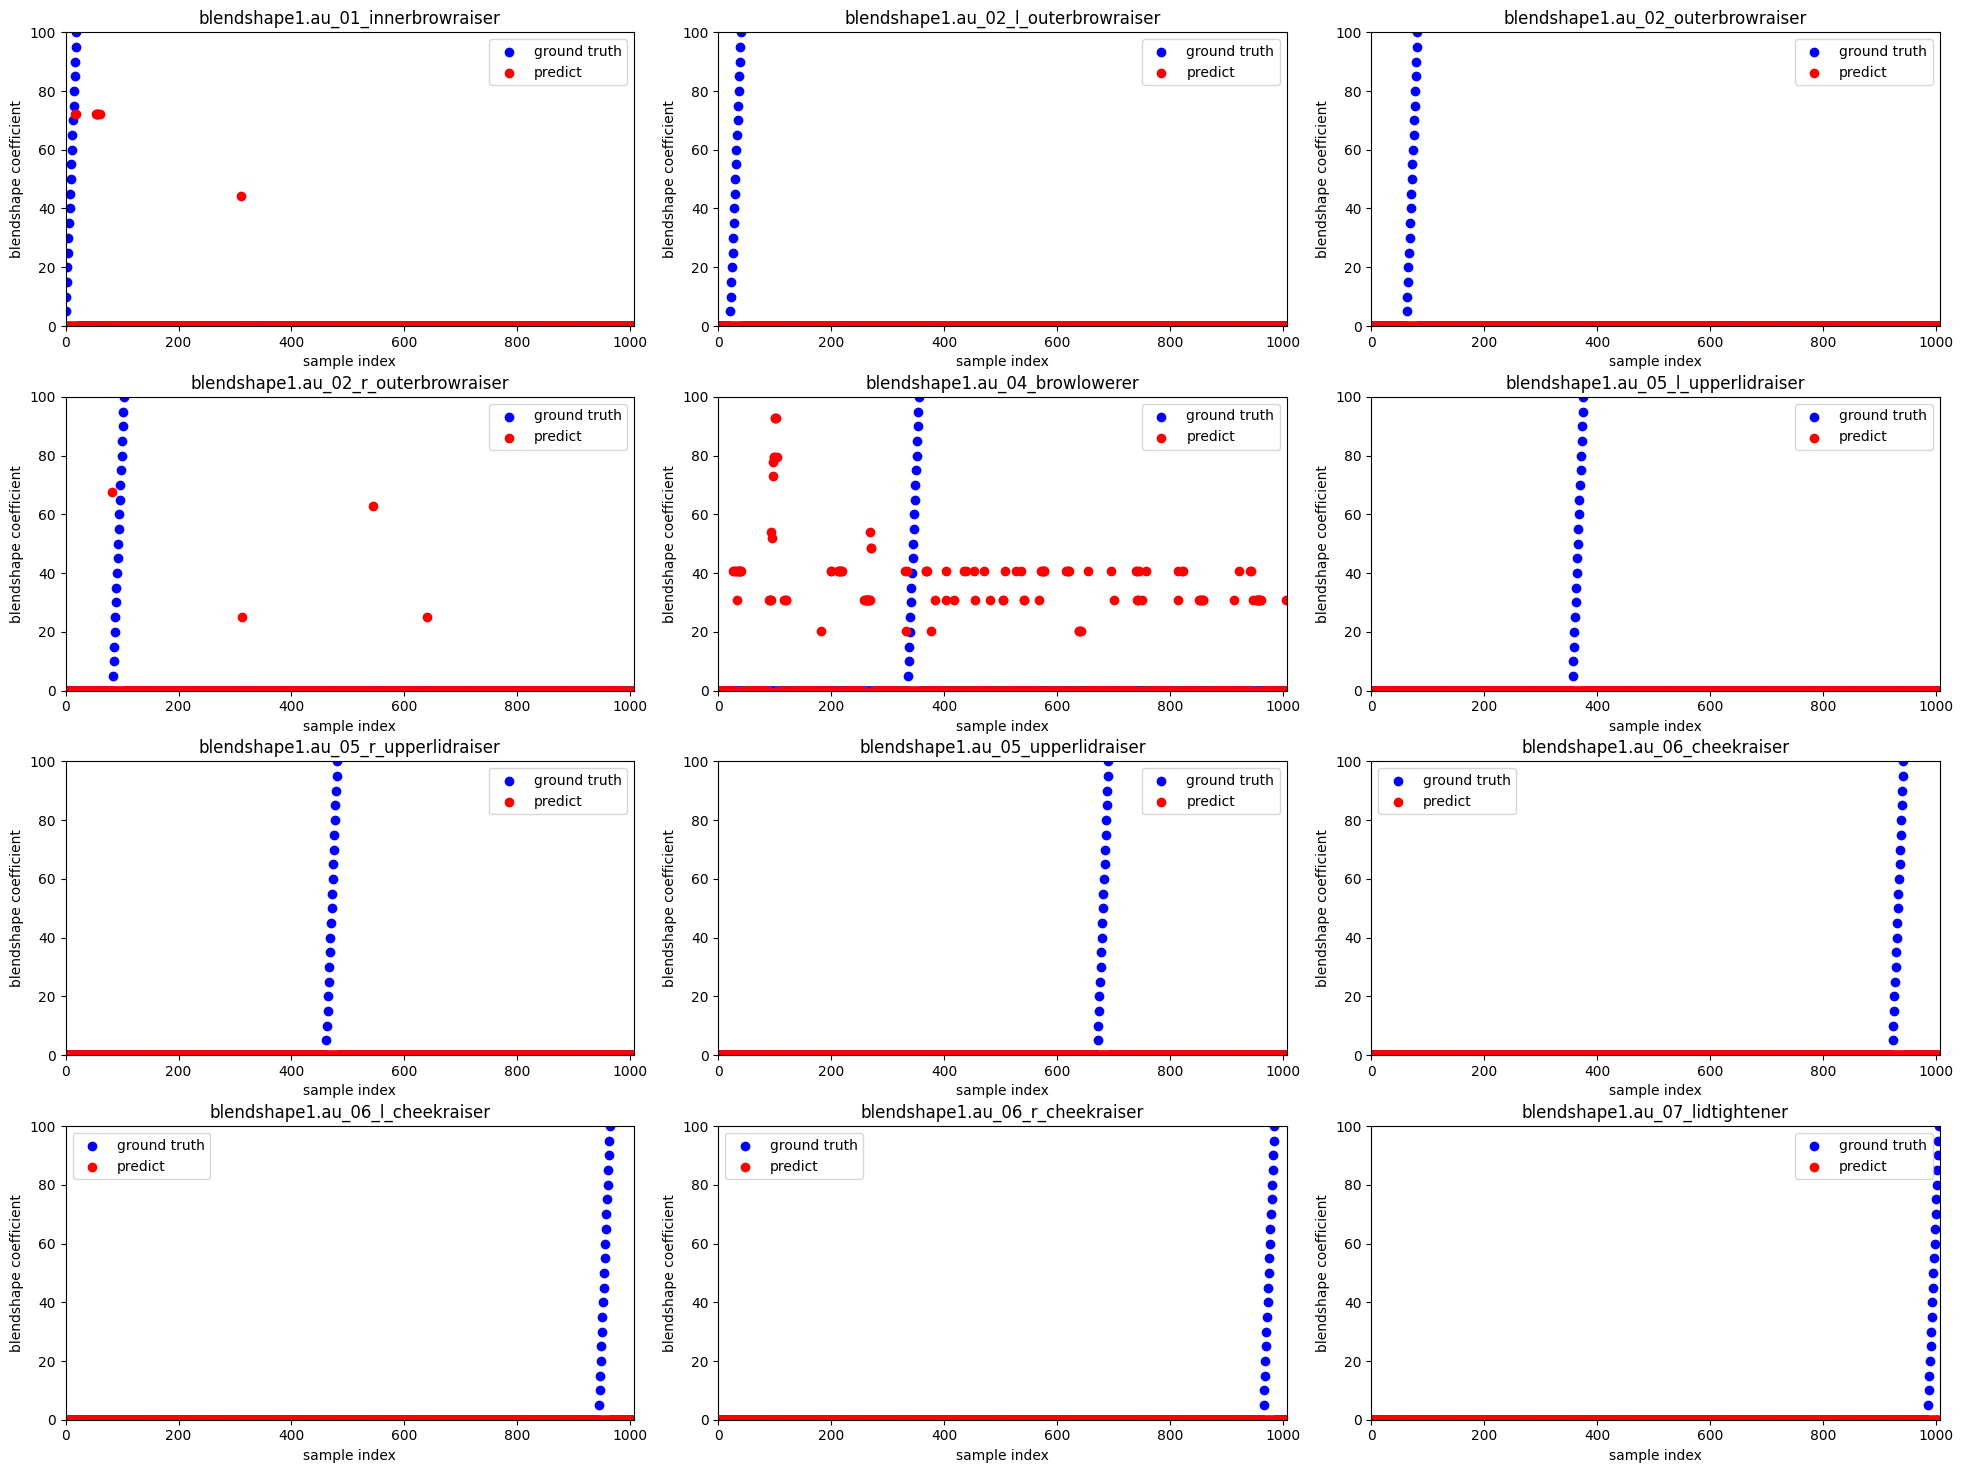

In [248]:
ncols = 3
nrows = (len(in_used_blendshape_indices) // ncols) \
    if len(in_used_blendshape_indices) % ncols == 0 \
    else (len(in_used_blendshape_indices) // ncols + 1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
fig.tight_layout(pad = 3.0)

blendshape_name = list(blendshape_configs.keys())
# Modify here if another model is need to evaluate.
evaluating_search = fulldistance_dtregression_search
estimator = evaluating_search.best_estimator_

predicted_Y = DataFrame(estimator.predict(test_X))
for idx, blendshape_idx in enumerate(in_used_blendshape_indices):
    cur_test_Y = test_Y.iloc[:, blendshape_idx]
    n_test_samples = cur_test_Y.shape[0]
    sample_idx = [i for i in range(n_test_samples)]
    predict_y = predicted_Y.iloc[:, idx]
    cur_axes = axes[idx // ncols][idx % ncols]
    cur_axes.set_xlim(0, n_test_samples)
    cur_axes.set_ylim(0, 100)
    cur_axes.scatter(sample_idx, cur_test_Y, c='blue', label='ground truth')
    cur_axes.scatter(sample_idx, predict_y, c='red', label='predict')
    cur_axes.set_title(blendshape_name[idx])
    cur_axes.set_xlabel("sample index")
    cur_axes.set_ylabel("blendshape coefficient")
    cur_axes.legend() 

print("Max score:", max(res), "; min score:",  min(res))

In [246]:
from timeit import timeit

N = 1000
estimators = [search.best_estimator_ for search in distance_multi_dt_searches.values()]
test_time_X = test_X.iloc[:N, :]

def test_prediction_time():
    global estimators
    global test_time_X
    for estimator in estimators:
        estimator.predict(test_time_X)

n_repeat = 10
total_time = timeit(test_prediction_time, number=n_repeat)
average_time = total_time / n_repeat
print(f"Average time for prediction of {N} samples is {average_time:.2f} seconds.")


296.24892832200567
